In [1]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import Accuracy
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define transformation to normalize MNIST images
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes with mean and standard deviation of MNIST
])

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root='./data',  # Directory to store the data
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    root='./data',  # Directory to store the data
    train=False,
    download=True,
    transform=transform
)

# Split train dataset into training and validation subsets
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for train, validation, and test datasets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 27.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 29.9MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.10MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
class CNN(pl.LightningModule):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))  # Convolutional layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))  # Max pooling layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout layer with probability 0.5
        self.fc1 = nn.Linear(32 * 13 * 13, 100)  # Fully connected layer
        self.fc2 = nn.Linear(100, 10)  # Output layer
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)  # Training accuracy
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)  # Validation accuracy
        self.training_acc_per_epoch = []  # Store training accuracy
        self.validation_acc_per_epoch = []  # Store validation accuracy

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Convolution + ReLU + Pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(x)  # Apply dropout before the first dense (linear) layer
        x = F.relu(self.fc1(x))  # Fully connected layer 1 with ReLU
        x = self.fc2(x)  # Fully connected layer 2 (output)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.train_accuracy.update(y_hat, y)  # Update training accuracy
        loss = nn.CrossEntropyLoss()(y_hat, y)  # Cross-entropy loss
        return loss

    def on_train_epoch_end(self):
        train_acc = self.train_accuracy.compute()
        self.training_acc_per_epoch.append(train_acc.item())  # Store training accuracy
        self.log('train_accuracy', train_acc)
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.val_accuracy.update(y_hat, y)  # Update validation accuracy
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss

    def on_validation_epoch_end(self):
        val_acc = self.val_accuracy.compute()
        self.validation_acc_per_epoch.append(val_acc.item())  # Store validation accuracy
        self.log('val_accuracy', val_acc)
        self.val_accuracy.reset()

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

In [4]:
# # Part (d) - Training for 2 epochs and testing
# print("### PART D: Training for 2 epochs ###")
# model_d = CNN()
# trainer_d = pl.Trainer(
#     max_epochs=2,  # 2 epochs as required in part (d)
#     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
#     devices=1
# )
# trainer_d.fit(model_d, train_loader, val_loader)
# trainer_d.test(model_d, test_loader)

# # Part (e-I) - Training for 10 epochs and plotting
# print("\n### PART E: Training for 10 epochs ###")
# model_e = CNN()
# trainer_e = pl.Trainer(
#     max_epochs=10,  # 10 epochs as required in part (e)
#     accelerator='gpu' if torch.cuda.is_available() else 'cpu',
#     devices=1
# )
# trainer_e.fit(model_e, train_loader, val_loader)

# # Plot Training and Validation Accuracy
# epochs = range(1, len(model_e.training_acc_per_epoch) + 1)
# plt.figure(figsize=(8, 6))
# plt.plot(epochs, model_e.training_acc_per_epoch, label='Training Accuracy')
# plt.plot(epochs, model_e.validation_acc_per_epoch, label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.grid(True)
# plt.show()

# part (e-II)
# Train the CNN with Dropout
model_with_dropout = CNN()

trainer = pl.Trainer(
    max_epochs=10,  # Train for 10 epochs
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1
)

# Train the model
trainer.fit(model_with_dropout, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name           | Type               | Params | Mode 
------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|█████████████████████| 1688/1688 [00:18<00:00, 90.73it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████| 1688/1688 [00:19<00:00, 84.83it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████| 1688/1688 [00:20<00:00, 81.48it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████| 1688/1688 [00:16<00:00, 99.86it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████| 1688/1688 [00:18<00:00, 91.82it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████| 1688/1688 [00:20<00:00, 82.42it/s, v_num=0]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████| 1688/1688 [00:14<00:00, 114.30it/s, v_num=0]


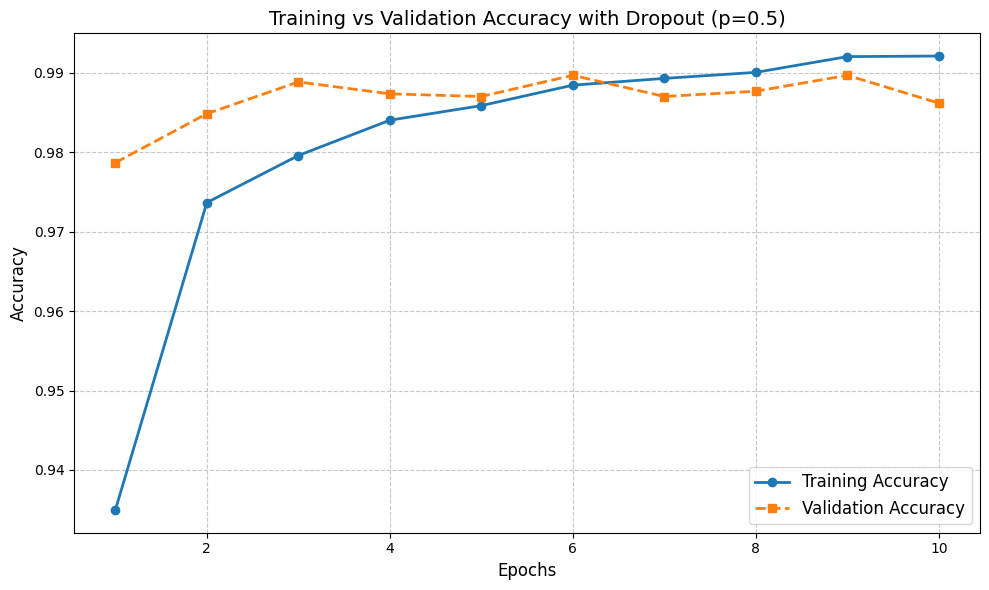

In [8]:
# Plot Training and Validation Accuracy
epochs = range(1, len(model_with_dropout.training_acc_per_epoch) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, model_with_dropout.training_acc_per_epoch, label='Training Accuracy', marker='o', linestyle='-', linewidth=2)
plt.plot(epochs, model_with_dropout.validation_acc_per_epoch[1:], label='Validation Accuracy', marker='s', linestyle='--', linewidth=2)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Validation Accuracy with Dropout (p=0.5)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [9]:
# part e - III
class CNN(pl.LightningModule):
    def __init__(self):
        super(CNN, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))  # 32 filters, kernel 3x3
        self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))  # First pooling layer
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))  # 64 filters, kernel 3x3
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))  # Second pooling layer
        
        # Dropout layer
        self.dropout = nn.Dropout(p=0.5)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 5 * 5, 100)  # Adjusted for new convolutional layers
        self.fc2 = nn.Linear(100, 10)  # Output layer
        
        # Metrics for accuracy
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.training_acc_per_epoch = []  # To store training accuracy
        self.validation_acc_per_epoch = []  # To store validation accuracy

    def forward(self, x):
        # First convolutional block
        x = self.pool1(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool1
        
        # Second convolutional block
        x = self.pool2(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool2
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dropout
        x = self.dropout(x)
        
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.train_accuracy.update(y_hat, y)  # Update training accuracy
        loss = nn.CrossEntropyLoss()(y_hat, y)  # Cross-entropy loss
        return loss

    def on_train_epoch_end(self):
        train_acc = self.train_accuracy.compute()
        self.training_acc_per_epoch.append(train_acc.item())  # Store training accuracy
        self.log('train_accuracy', train_acc)
        self.train_accuracy.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        self.val_accuracy.update(y_hat, y)  # Update validation accuracy
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return loss

    def on_validation_epoch_end(self):
        val_acc = self.val_accuracy.compute()
        self.validation_acc_per_epoch.append(val_acc.item())  # Store validation accuracy
        self.log('val_accuracy', val_acc)
        self.val_accuracy.reset()

    def configure_optimizers(self):
        return optim.SGD(self.parameters(), lr=0.01, momentum=0.9)

In [10]:
# Train the CNN with an additional convolutional layer
model_with_two_convs = CNN()

trainer = pl.Trainer(
    max_epochs=10,  # Train for 10 epochs
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1
)

# Train the model
trainer.fit(model_with_two_convs, train_loader, val_loader)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool1          | MaxPool2d          | 0      | train
2 | conv2          | Conv2d             | 18.5 K | train
3 | pool2          | MaxPool2d          | 0      | train
4 | dropout        | Dropout            | 0      | train
5 | fc1            | Linear             | 160 K  | train
6 | fc2            | Linear             | 1.0 K  | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.720     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Epoch 0: 100%|█████████████████████| 1688/1688 [00:25<00:00, 66.85it/s, v_num=1]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████| 1688/1688 [00:23<00:00, 70.51it/s, v_num=1]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████| 1688/1688 [00:24<00:00, 67.78it/s, v_num=1]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████| 1688/1688 [00:23<00:00, 72.70it/s, v_num=1]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████| 1688/1688 [00:22<00:00, 74.71it/s, v_num=1]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████| 1688/1688 [00:23<00:00, 72.67it/s, v_num=1]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████| 1688/1688 [00:25<00:00, 66.17it/s, v_num=1]


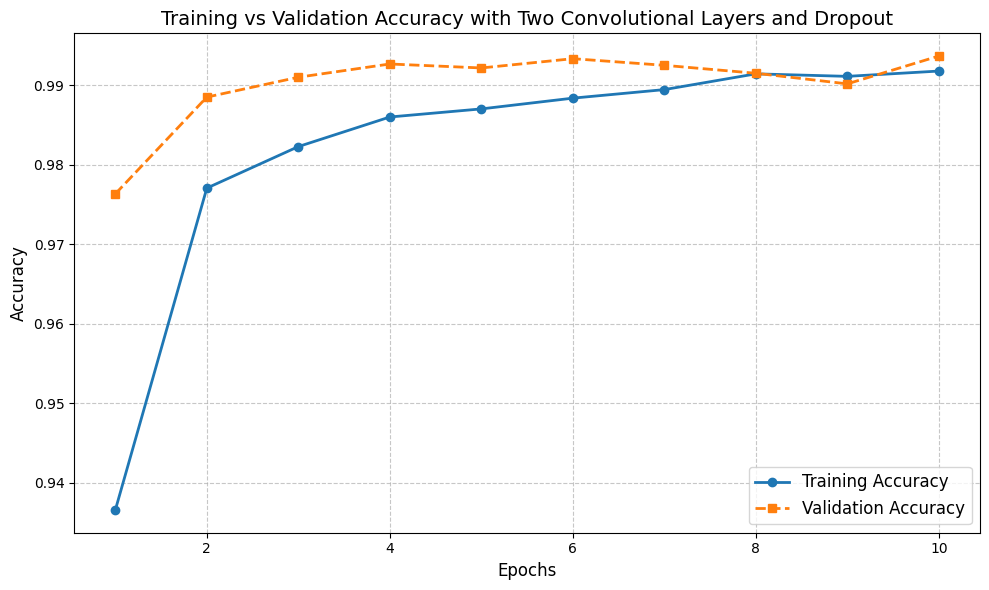

In [11]:
# Plot Training and Validation Accuracy
epochs = range(1, len(model_with_two_convs.training_acc_per_epoch) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, model_with_two_convs.training_acc_per_epoch, label='Training Accuracy', marker='o', linestyle='-', linewidth=2)
plt.plot(epochs, model_with_two_convs.validation_acc_per_epoch[1:], label='Validation Accuracy', marker='s', linestyle='--', linewidth=2)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Validation Accuracy with Two Convolutional Layers and Dropout', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [12]:
# Part E-IV

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool1          | MaxPool2d          | 0      | train
2 | conv2          | Conv2d             | 18.5 K | train
3 | pool2          | MaxPool2d          | 0      | train
4 | dropout        | Dropout            | 0      | train
5 | fc1            | Linear             | 160 K  | train
6 | fc2            | Linear             | 1.0 K  | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.720     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Epoch 0: 100%|█████████████████████| 1688/1688 [00:24<00:00, 68.14it/s, v_num=2]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████| 1688/1688 [00:22<00:00, 73.45it/s, v_num=2]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████| 1688/1688 [00:23<00:00, 72.39it/s, v_num=2]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████| 1688/1688 [00:26<00:00, 63.07it/s, v_num=2]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████| 1688/1688 [00:26<00:00, 63.88it/s, v_num=2]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████| 1688/1688 [00:25<00:00, 65.30it/s, v_num=2]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████| 1688/1688 [00:26<00:00, 63.68it/s, v_num=2]


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 320    | train
1 | pool1          | MaxPool2d          | 0      | train
2 | conv2          | Conv2d             | 18.5 K | train
3 | pool2          | MaxPool2d          | 0      | train
4 | dropout        | Dropout            | 0      | train
5 | fc1            | Linear             | 160 K  | train
6 | fc2            | Linear             | 1.0 K  | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
179 K     Trainable params
0         Non-trainable params
179 K     Total params
0.720     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval

Epoch 0: 100%|█████████████████████| 1688/1688 [00:24<00:00, 67.90it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████| 1688/1688 [00:22<00:00, 76.49it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████| 1688/1688 [00:24<00:00, 69.61it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████| 1688/1688 [00:23<00:00, 71.47it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████| 1688/1688 [00:24<00:00, 69.66it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████| 1688/1688 [00:25<00:00, 66.99it/s, v_num=3]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|█████████████████████| 1688/1688 [00:26<00:00, 64.51it/s, v_num=3]


ValueError: x and y must have same first dimension, but have shapes (10,) and (11,)

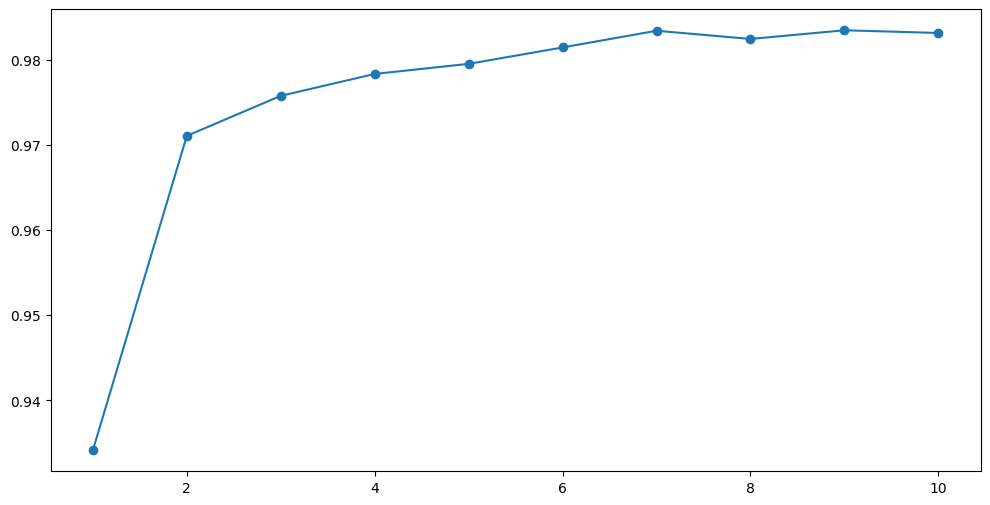

In [13]:
# Define a helper function for training and storing results
def train_model_with_lr(learning_rate, train_loader, val_loader):
    class CNN(pl.LightningModule):
        def __init__(self):
            super(CNN, self).__init__()
            self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
            self.pool1 = nn.MaxPool2d(kernel_size=(2, 2))
            self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3))
            self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
            self.dropout = nn.Dropout(p=0.5)
            self.fc1 = nn.Linear(64 * 5 * 5, 100)
            self.fc2 = nn.Linear(100, 10)
            self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
            self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
            self.training_acc_per_epoch = []
            self.validation_acc_per_epoch = []

        def forward(self, x):
            x = self.pool1(F.relu(self.conv1(x)))
            x = self.pool2(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = self.dropout(x)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

        def training_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.forward(x)
            self.train_accuracy.update(y_hat, y)
            loss = nn.CrossEntropyLoss()(y_hat, y)
            return loss

        def on_train_epoch_end(self):
            train_acc = self.train_accuracy.compute()
            self.training_acc_per_epoch.append(train_acc.item())
            self.log('train_accuracy', train_acc)
            self.train_accuracy.reset()

        def validation_step(self, batch, batch_idx):
            x, y = batch
            y_hat = self.forward(x)
            self.val_accuracy.update(y_hat, y)
            loss = nn.CrossEntropyLoss()(y_hat, y)
            return loss

        def on_validation_epoch_end(self):
            val_acc = self.val_accuracy.compute()
            self.validation_acc_per_epoch.append(val_acc.item())
            self.log('val_accuracy', val_acc)
            self.val_accuracy.reset()

        def configure_optimizers(self):
            return optim.SGD(self.parameters(), lr=learning_rate, momentum=0.9)

    # Instantiate the model
    model = CNN()

    # Trainer for 10 epochs
    trainer = pl.Trainer(
        max_epochs=10,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1
    )

    # Train the model
    trainer.fit(model, train_loader, val_loader)

    # Return the training and validation accuracy logs
    return model.training_acc_per_epoch, model.validation_acc_per_epoch

# Train and log results for each learning rate
lr_003 = 0.03
lr_0003 = 0.003

# Train with learning rate 0.03
training_acc_003, validation_acc_003 = train_model_with_lr(lr_003, train_loader, val_loader)

# Train with learning rate 0.003
training_acc_0003, validation_acc_0003 = train_model_with_lr(lr_0003, train_loader, val_loader)

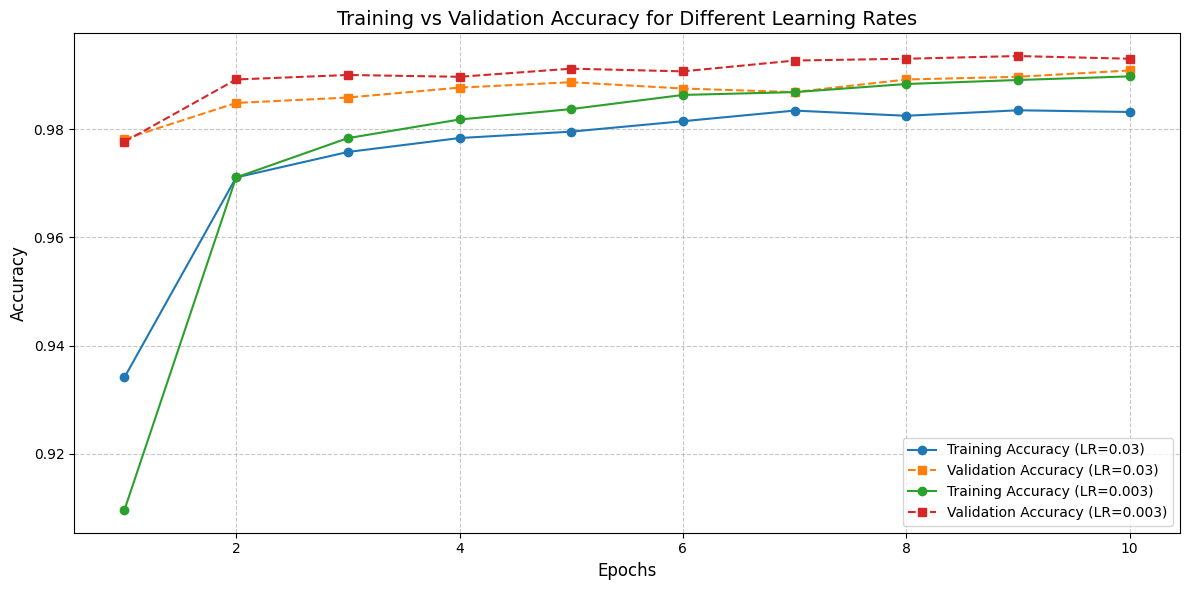

In [14]:
# Plot the results
epochs = range(1, 11)

plt.figure(figsize=(12, 6))

# Plot for learning rate 0.03
plt.plot(epochs, training_acc_003, label='Training Accuracy (LR=0.03)', marker='o', linestyle='-')
plt.plot(epochs, validation_acc_003[1:], label='Validation Accuracy (LR=0.03)', marker='s', linestyle='--')

# Plot for learning rate 0.003
plt.plot(epochs, training_acc_0003, label='Training Accuracy (LR=0.003)', marker='o', linestyle='-')
plt.plot(epochs, validation_acc_0003[1:], label='Validation Accuracy (LR=0.003)', marker='s', linestyle='--')

# Customize plot
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training vs Validation Accuracy for Different Learning Rates', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Programming exercise 2

### Part A

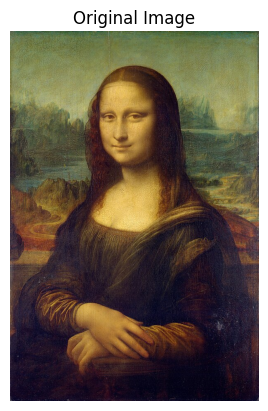

In [3]:
# Import necessary libraries
from PIL import Image

image_path = 'mona_lisa.jpg'
image = Image.open(image_path)

plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
plt.show()

### Part B

In [7]:
import numpy as np

image_array = np.array(image)
height, width, _ = image_array.shape

np.random.seed(42) 
num_samples = 5000
x_coords = np.random.randint(0, width, size=num_samples)
y_coords = np.random.randint(0, height, size=num_samples)

X = np.stack((x_coords, y_coords), axis=1)

### Part C

In [8]:
# Extract pixel values at sampled coordinates
pixel_values = image_array[y_coords, x_coords]

# Normalize pixel values to [0, 1] range
Y = pixel_values / 255.0

### Part D

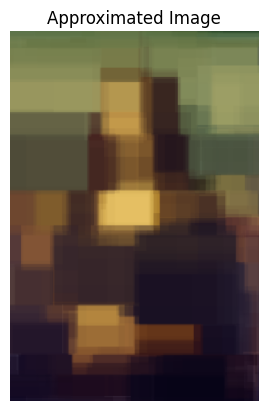

In [9]:
from sklearn.ensemble import RandomForestRegressor

# Train a random forest regressor
rf = RandomForestRegressor(n_estimators=10, max_depth=7, random_state=42)
rf.fit(X, Y)

# Generate the approximated image
approx_image_array = np.zeros_like(image_array, dtype=float)
for y in range(height):
    for x in range(width):
        approx_image_array[y, x] = rf.predict([[x, y]])

# Convert back to [0, 255] range and to PIL image
approx_image_array = (approx_image_array * 255).astype(np.uint8)
approx_image = Image.fromarray(approx_image_array)

# Display the approximated image
plt.imshow(approx_image)
plt.title('Approximated Image')
plt.axis('off')
plt.show()

### Part E

#### Part E - I

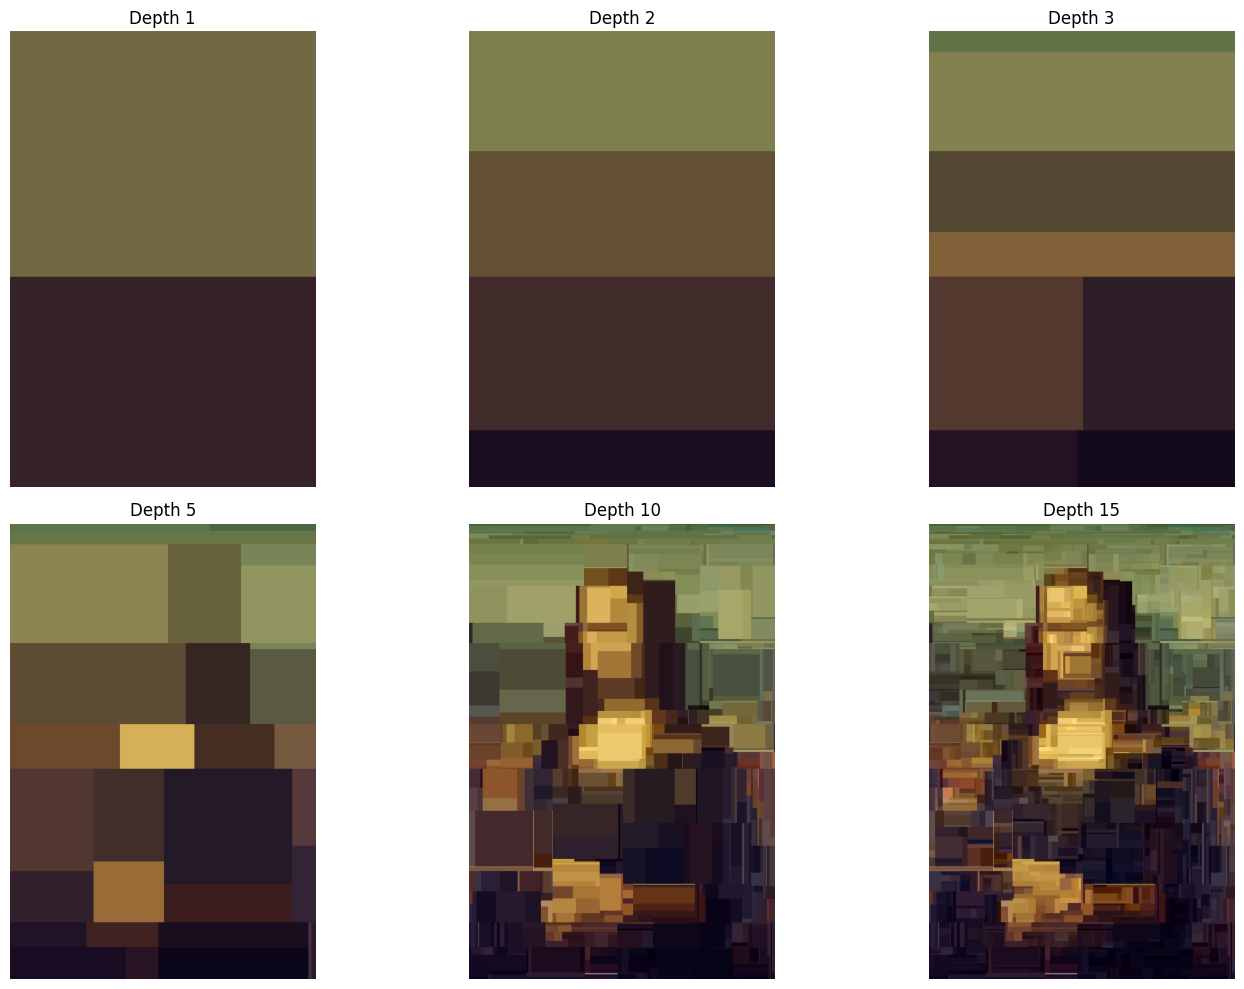

In [21]:
depths = [1, 2, 3, 5, 10, 15]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, depth in enumerate(depths):
    rf = RandomForestRegressor(n_estimators=1, max_depth=depth, random_state=42)
    rf.fit(X, Y)
    
    approx_image_array = np.zeros_like(image_array, dtype=float)
    for y in range(height):
        for x in range(width):
            approx_image_array[y, x] = rf.predict([[x, y]])
    
    approx_image_array = (approx_image_array * 255).astype(np.uint8)
    approx_image = Image.fromarray(approx_image_array)
    
    ax = axes[i // 3, i % 3]
    ax.imshow(approx_image)
    ax.set_title(f'Depth {depth}')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Part E - II

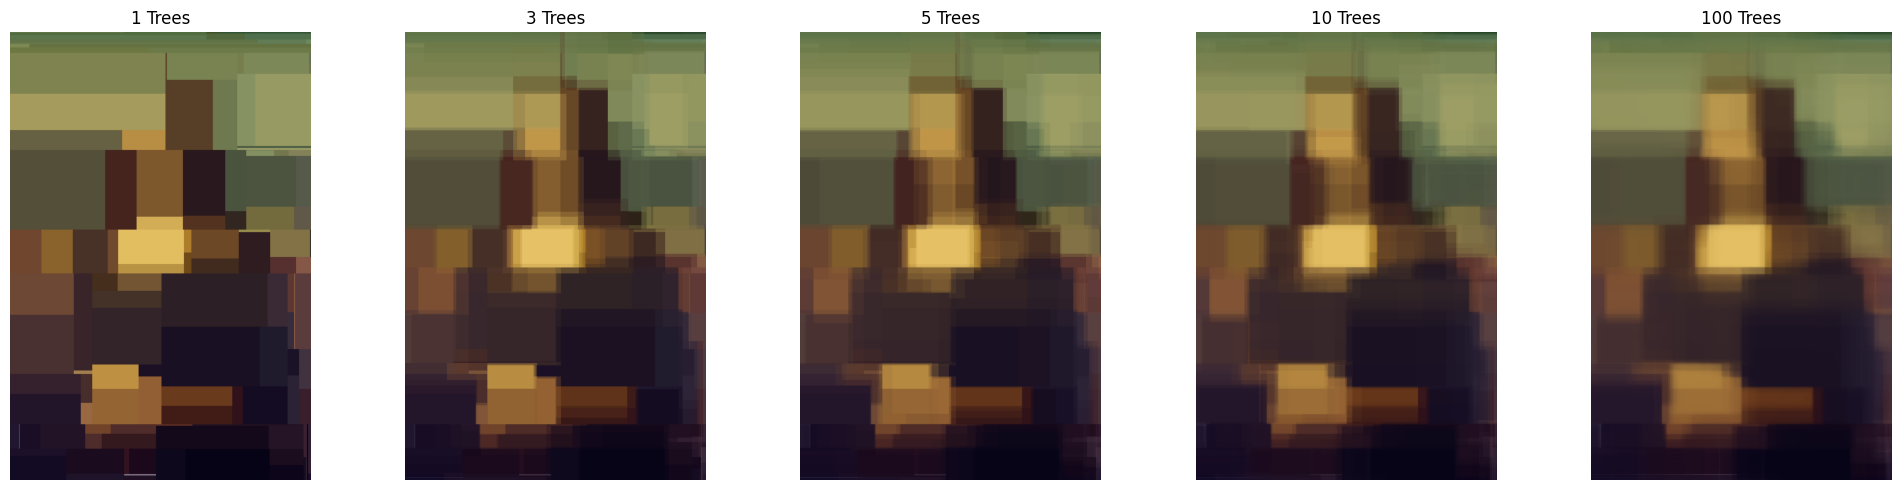

'\n\\textbf{Impact of Number of Trees:}\nMore trees improve approximation by reducing variance, resulting in smoother images. Too few trees may underfit the image data.\n'

In [22]:
num_trees = [1, 3, 5, 10, 100]
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, n_trees in enumerate(num_trees):
    rf = RandomForestRegressor(n_estimators=n_trees, max_depth=7, random_state=42)
    rf.fit(X, Y)
    
    approx_image_array = np.zeros_like(image_array, dtype=float)
    for y in range(height):
        for x in range(width):
            approx_image_array[y, x] = rf.predict([[x, y]])
    
    approx_image_array = (approx_image_array * 255).astype(np.uint8)
    approx_image = Image.fromarray(approx_image_array)
    
    ax = axes[i]
    ax.imshow(approx_image)
    ax.set_title(f'{n_trees} Trees')
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Part E - III

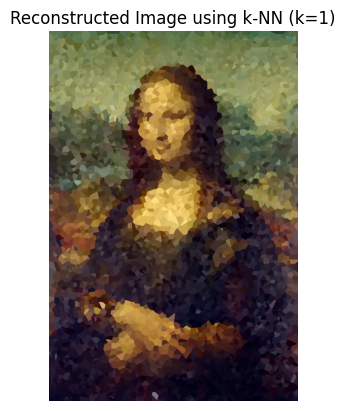

"\n\\textbf{Comparison of k-NN (k=1) with Random Forest:}\n1. The k-NN method assigns the nearest sampled pixel's RGB value to each pixel in the image.\n2. This results in sharp, blocky regions of uniform color due to the direct nearest-neighbor assignment.\n3. In contrast, random forests produce smoother transitions between pixel values because they predict values using an average of multiple decision paths.\n4. k-NN is simpler and faster but lacks the ability to generalize and smooth the approximations, making it less suitable for high-quality image reconstruction.\n"

In [23]:
from sklearn.neighbors import KNeighborsRegressor

# Train a k-NN regressor
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(X, Y)  # Train on (x, y) -> (r, g, b)

# Generate the approximated image using k-NN
knn_image_array = np.zeros((height, width, 3), dtype=float)

for y in range(height):
    for x in range(width):
        knn_image_array[y, x] = knn.predict([[x, y]])

# Convert normalized RGB values back to [0, 255] range for display
knn_image_array = (knn_image_array * 255).astype(np.uint8)
knn_image = Image.fromarray(knn_image_array)

# Display the k-NN reconstructed image
plt.imshow(knn_image)
plt.title('Reconstructed Image using k-NN (k=1)')
plt.axis('off')
plt.show()

#### Part E - IV

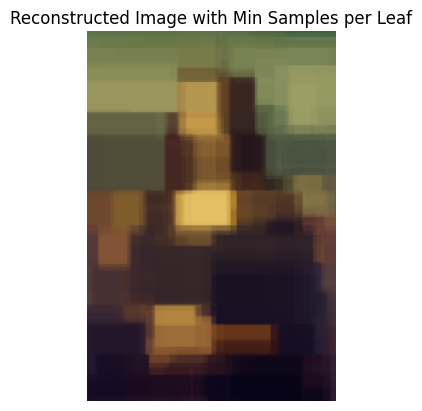

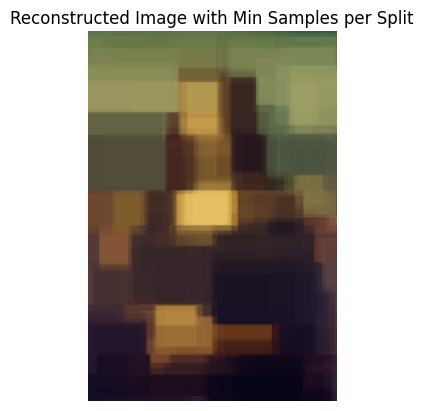

'\n\\textbf{Pruning Strategies and Results:}\n1. \\textbf{Min Samples per Leaf:} Reduces overfitting by ensuring that each leaf node has enough data to make meaningful predictions. The result is smoother approximations with fewer overly specific regions.\n2. \\textbf{Min Samples per Split:} Prevents excessively granular splits by requiring a minimum number of samples to justify a new split. This strategy also improves generalization and reduces overfitting.\n3. Both methods help control the complexity of the model, balancing the trade-off between accuracy and generalization.\n'

In [24]:
# Pruning Strategy 1: Minimum Samples per Leaf Node
rf_min_samples_leaf = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_leaf=5, random_state=42)
rf_min_samples_leaf.fit(X, Y)

# Generate the image
leaf_image_array = np.zeros((height, width, 3), dtype=float)
for y in range(height):
    for x in range(width):
        leaf_image_array[y, x] = rf_min_samples_leaf.predict([[x, y]])

leaf_image_array = (leaf_image_array * 255).astype(np.uint8)
leaf_image = Image.fromarray(leaf_image_array)

# Display the reconstructed image
plt.imshow(leaf_image)
plt.title('Reconstructed Image with Min Samples per Leaf')
plt.axis('off')
plt.show()

# Pruning Strategy 2: Minimum Samples per Split
rf_min_samples_split = RandomForestRegressor(n_estimators=10, max_depth=7, min_samples_split=10, random_state=42)
rf_min_samples_split.fit(X, Y)

# Generate the image
split_image_array = np.zeros((height, width, 3), dtype=float)
for y in range(height):
    for x in range(width):
        split_image_array[y, x] = rf_min_samples_split.predict([[x, y]])

split_image_array = (split_image_array * 255).astype(np.uint8)
split_image = Image.fromarray(split_image_array)

# Display the reconstructed image
plt.imshow(split_image)
plt.title('Reconstructed Image with Min Samples per Split')
plt.axis('off')
plt.show() 